In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
from binary_c_API import evolve_binary
import os
import rebound
from rebound.interruptible_pool import InterruptiblePool
import xml.etree.ElementTree as ET, urllib.request, gzip, io
from query_catalog_CBPs import find_CBPs

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 20
%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

# Make cells narrower for better typography
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

In [8]:
def simulation(params):
    """
    Runs a single rebound simulation and calculates the MEGNO value.
    
    This function sets up a single rebound simulation, and calculates the MEGNO value
    based on the approach described in the Rein & Tamayo paper on variational equations.
    
    Parameters
    -----------
    m1 : float
        Mass of the first body in msun.
    m2 : float
        Mass of the second body in msun.
    m3 : float
        Mass of the third body in msun.
    P_i : float
        Period of the 'inner binary' in days.
    e_i : float
        Eccentricity of the inner binary.
    P_o : float
        Period of the 'outer binary' in days.
    e_o : float
        Eccentricity of the outer binary
    
    Returns
    -------
    megno : float
        The MEGNO value for the chosen system parameters.
    """

    m1, m2, m3, P_i, e_i, P_o, e_o, integration_time = params
    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    
    # Convert periods to rebound units
    P_i *= 2*np.pi/365.25 # 2pi*years
    P_o *= 2*np.pi/365.25 
    
    sim.dt = P_i/10
    sim.add(m=m1)
    sim.add(m=m2, P=P_i, e=e_i) 
    sim.add(m=m3, P=P_o, e=e_o) 

    sim.move_to_com()
    sim.init_megno()
    sim.exit_max_distance = 20.
    try:
        sim.integrate(integration_time*2.*np.pi, exact_finish_time=0) # integrate 
        # for 500 years, integrating to the nearest
        #timestep for each output to keep the timestep constant and preserve WHFast's symplectic nature
        megno = sim.calculate_megno()
        return megno
    except rebound.Escape:
        return 10. # At least one particle got ejected, returning large MEGNO.

def resonance_width(m1, m2, m3, e_i, e_o, n):
    """
    Calculates the resonance width of an n-th order resonance in units of the 
    'inner binary' period. 
    """
    m123 = m1 + m2 + m3
    m12 = m1 + m2
    
    xi = np.arccosh(1/e_o) - np.sqrt(1 - e_o**2)
    width = (6*0.71**.5/((2*np.pi)**(1/4.)))*\
            (m3/m123 + n**(2/3.) *(m12/m123)**(2/3.)*(m1*m2/m12**2))**.5 *\
            (e_i**.5/e_o)*(1 - 13/24.*e_i**2.)**.5*(1 - e_o**2)**(3/8.)*\
            n**(3/4.)*np.exp(-n*xi/2.);
    return width

def stability_plot(params):
    """
    Plots a MEGNO map of a given system, together with resonant widths.
    
    For a given set of system parameters, the function plots a heat map 
    of MEGNO values as a function of period and 'outer binary' eccentricity.
    On top of this map it also plots the analytical prediction for resonant widths.
    
    Parameters
    ----------
    ax : matplotlib axes object
    
    m1 : float
        Mass of the first body in msun.
    m2 : float
        Mass of the second body in msun.
    m3 : float
        Mass of the third body in msun.
    P_i : float
        Period of the 'inner binary' in days.
    e_i : float
        Eccentricity of the inner binary."""

    m1, m2, m3, P_i, e_i, integration_time = params

    # Grid resolution
    N = 5
    
    P_outer = np.linspace(1., 15.2, N)*P_i
    e_outer = np.linspace(0., 0.82, N)

    parameters = []

    for e in e_outer:
        for P in P_outer:
            parameters.append((m1, m2, m3, P_i, e_i, P, e, integration_time))

    # This part uses parallelization 
    pool = InterruptiblePool()
    results = pool.map(simulation, parameters)
    results2d = np.array(results).reshape(N, N)
    x = (P_outer - (P_outer[1] - P_outer[0])/2)/P_i # shift ticks to center of cell
    y = e_outer - (e_outer[1] - e_outer[0])/2
    
    return x, y, results2d

In [9]:
# m1 = 1.
# m2 = 0.5
# m3 = 1e-03
# e_i = 0.1
# P_i = 10

# integration_time = 500

# params = [m1, m2, m3, P_i, e_i, integration_time]
# x, y, z = stability_plot(params)
# x2, y2, z2 = stability_plot([m1,m2,m3,P_i,e_i, 10000])

NameError: name 'x' is not defined

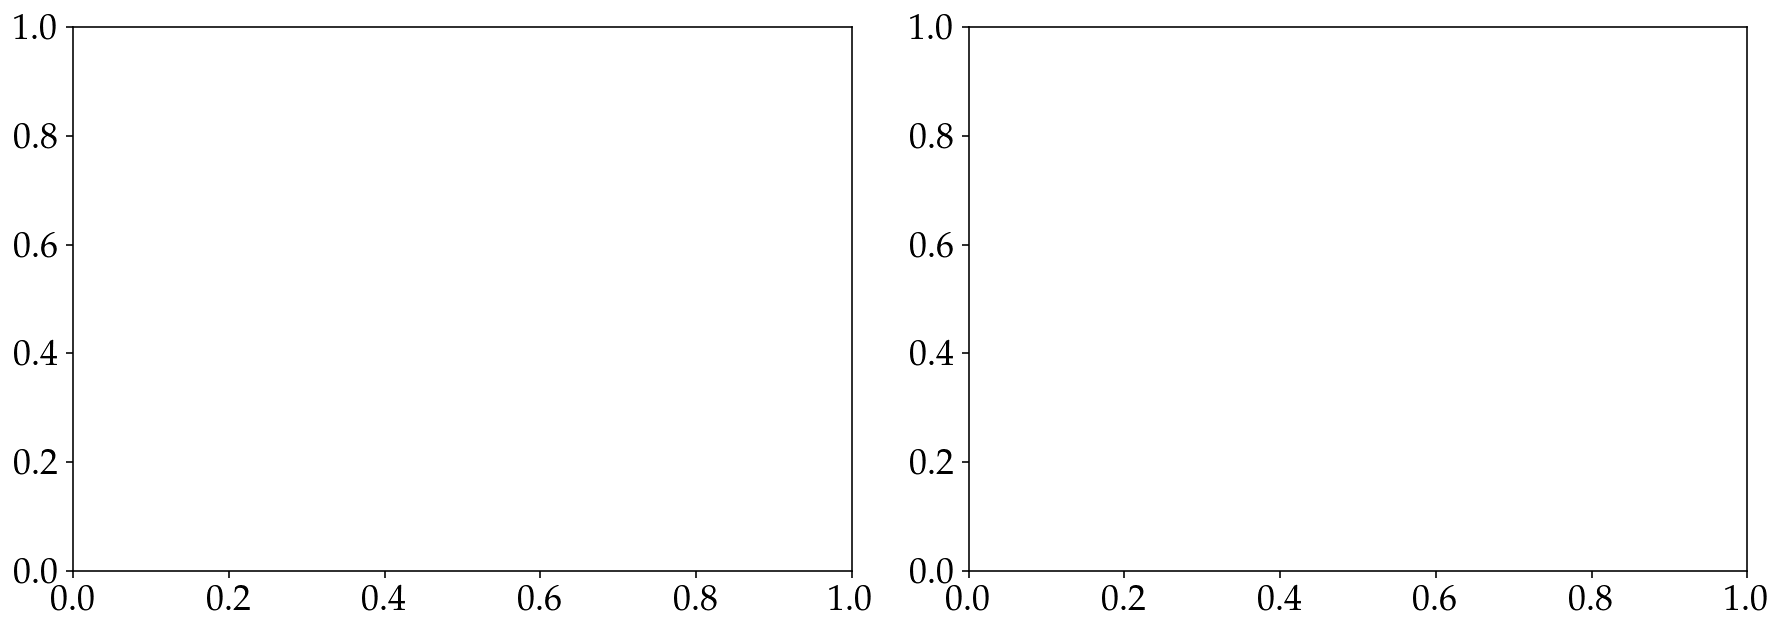

In [10]:
# Plot MEGNO stability map
fig, ax = plt.subplots(1,2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.15)

im = ax[0].pcolormesh(x, y, z, vmin=1.9, vmax=4)
im2 = ax[1].pcolormesh(x2, y2, z2, vmin=1.9, vmax=4)

im.set_edgecolor('face') # remove white lines in some pdf viewers

cb = fig.colorbar(im, ax=ax.ravel().tolist(), pad=0.01)
cb.set_label(r"MEGNO $\langle Y \rangle$")

for a in ax.ravel():
    a.set_xlabel(r"$P_o/P_i$")
    a.set_ylim(0, 0.78)
    a.set_xticks(np.arange(1, 16))
    a.set_yticks(np.linspace(0.,0.8, 9))
    a.grid(True)

ax[0].set_ylabel(r" $e_o$")

for a in ax.ravel():
    a.set_aspect(12/0.78)
    
# plt.savefig('megno.pdf'.format(P, e), 
#                 bbox_inches='tight


# Plot resonance widths
# e_o = np.linspace(0, 1, 500) 

# for i, n in enumerate(range(2, 16)):
#     width = resonance_width(m1, m2, m3, e_i, e_o, n)   
#     ax.fill_betweenx(e_o, -width + n, width + n, facecolor='black', alpha=0.15)
#     ax.set_xlim(1, 14.9)

# Stability of Kepler planets

In [18]:
cbp_transit = find_CBPs('transit')

<class 'xml.etree.ElementTree.ElementTree'>
Total number of CBPs:  29 

2M 1938+4603 b - timing
DP Leo b - timing
FL Lyr b - timing
FW Tau b - imaging
HU Aqr (AB) b - timing
HU Aqr (AB) c - timing
HU Aqr (AB) d - timing
HW Vir (AB) b - timing
Kepler-1647 b - transit
Kepler-16 (AB) b - transit
Kepler-34 (AB) b - transit
Kepler-35 (AB) b - transit
Kepler-38 (AB) b - transit
Kepler-413 b - transit
Kepler-47 (AB) b - transit
Kepler-47 (AB) c - transit
KIC 9632895 b - transit
KOI-2939 b - transit
NN Ser (AB) c - timing
NN Ser (AB) d - timing
NSVS 14256825 c - timing
NSVS 14256825 d - timing
NY Virginis (AB) b - timing
PH-1 A(ab) b - transit
PSR B1620-26 b - timing
Ross 458 C - imaging
ROXs 42 B b - imaging
RR Cae (AB) b - timing
SR 12 C - imaging

Systems with multiple CBPs: 

HU Aqr , 3 planets
Kepler-47 , 2 planets
NN Ser A , 2 planets
NSVS 14256825 A , 2 planets


/home/fran/Drive/Work/master_thesis/notebooks/query_catalog_CBPs.py:79: RuntimeWarning: divide by zero encountered in double_scalars
  mstars[0]/mstars[1],


,m,m_erru,m_errorl,R,a,P,e,I,mstar1,mstar2,q,a_binary,P_binary,e_binary
Kepler-1647 b,1.520000,0.650000,0.650000,1.060000,2.72050,1107.5923,0.05810,90.0972,1.2100,0.97500,1.241026,0.127600,11.258820,0.16020
Kepler-16 (AB) b,0.333000,NaN,NaN,0.753800,0.70480,228.7760,0.00685,90.0322,0.6897,0.20255,3.405085,0.220000,41.000000,NaN
Kepler-34 (AB) b,0.220000,NaN,NaN,0.764000,1.08960,288.8220,0.18200,90.3550,1.0479,1.02080,1.026548,0.115909,27.795800,0.52087
Kepler-35 (AB) b,0.127000,NaN,NaN,0.728000,0.60347,131.4580,0.04200,90.7600,0.8900,0.81000,1.098765,0.176170,20.733000,0.14210
Kepler-38 (AB) b,NaN,0.000000,0.000000,0.396417,0.46440,105.5950,0.03200,90.1820,0.9490,0.24900,3.811245,0.146000,NaN,0.10320
Kepler-413 b,0.210762,0.069205,0.069205,0.396143,NaN,66.2620,0.11800,4.0730,0.8200,0.54230,1.512078,0.101480,10.116146,0.03720
Kepler-47 (AB) b,NaN,0.000000,0.000000,0.271568,0.29560,49.5140,NaN,89.5900,1.0430,0.36200,2.881215,0.083600,7.448300,0.02340
Kepler-47 (AB) c,NaN,0.000000,0.000000,0.420111,0.98900,303.1580,NaN,89.8260,1.0430,0.36200,2.881215,0.083600,7.448300,0.02340
KIC 9632895 b,0.019503,0.050331,0.050331,0.561818,0.78770,240.5030,0.03790,89.4338,0.9340,0.19380,4.819401,0.184790,27.322037,0.05100
KOI-2939 b,1.520000,0.648000,0.648000,1.059320,2.72050,1107.5923,0.05810,90.0972,1.2207,0.96780,1.261314,0.127600,11.258818,0.16020


/home/fran/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:66: RuntimeWarning: divide by zero encountered in true_divide
/home/fran/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:67: RuntimeWarning: divide by zero encountered in true_divide
/home/fran/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:67: RuntimeWarning: invalid value encountered in multiply


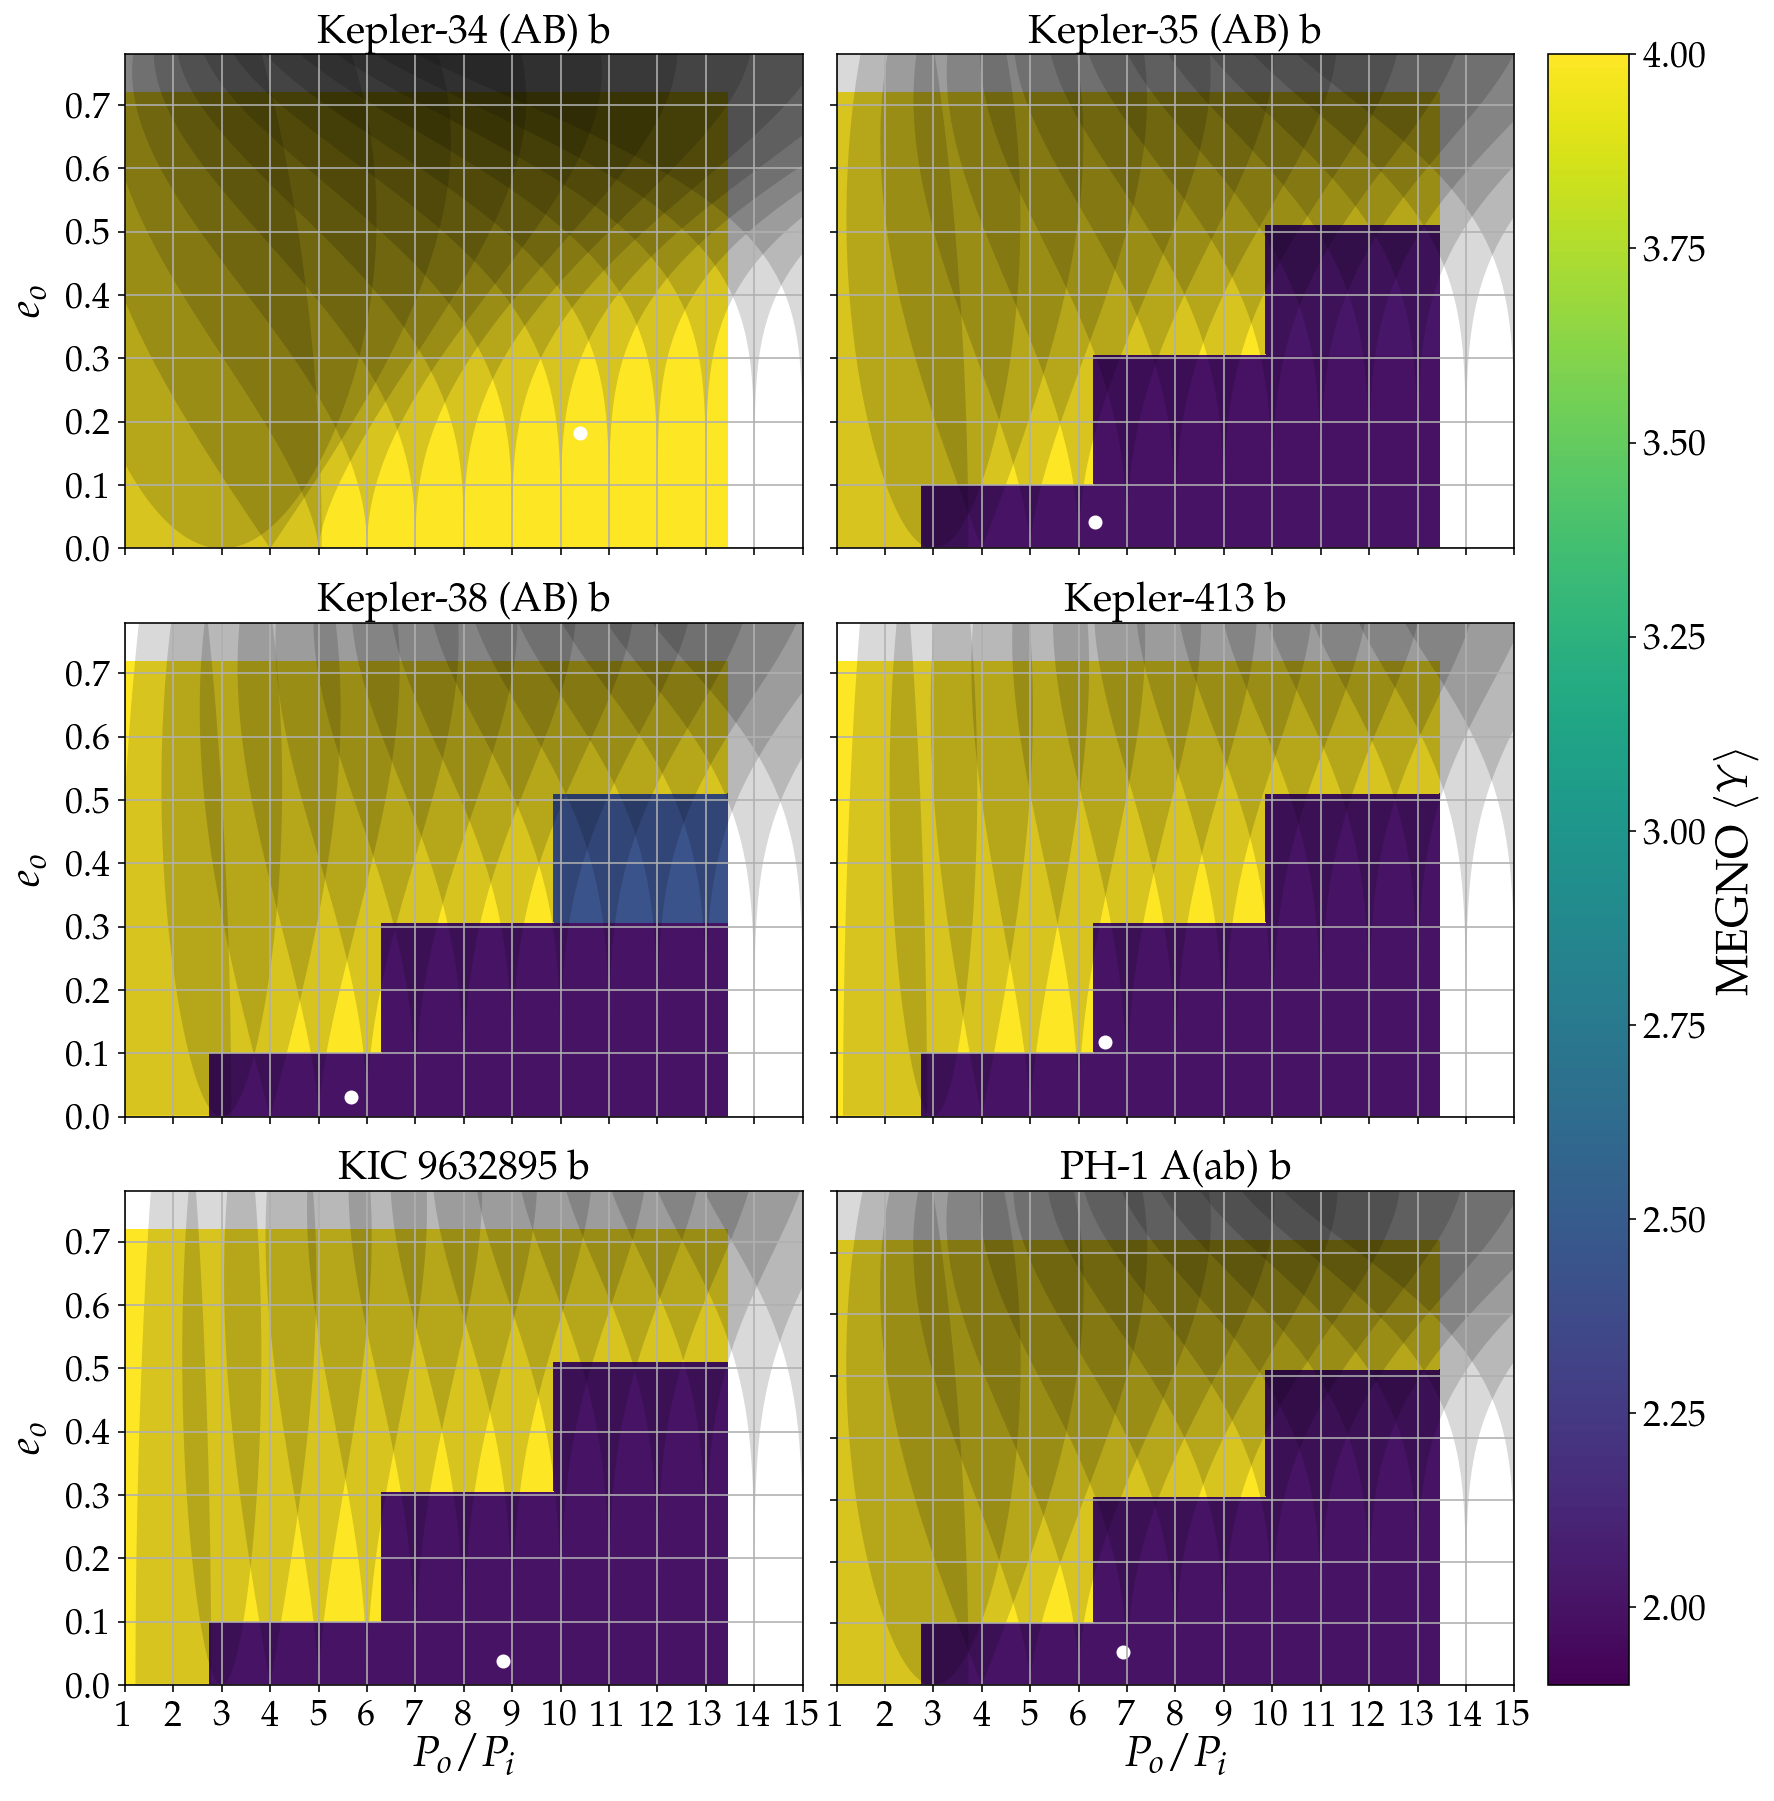

In [22]:
fig, ax = plt.subplots(3,2, figsize=(15,15), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.05, hspace=0.15)

k = 0

planet_list = ['Kepler-1647 b', 'Kepler-34 (AB) b', 'Kepler-35 (AB) b','Kepler-38 (AB) b',
              'Kepler-413 b', 'KIC 9632895 b','KOI-2939 b','PH-1 A(ab) b']

for i, name in enumerate(planet_list):        
    m1 = cbp_transit.loc[name,'mstar1']
    m2 = cbp_transit.loc[name,'mstar2']
    m3 = cbp_transit.loc[name,'m']*0.0009543
    a_i = cbp_transit.loc[name,'a_binary']
    P_i = cbp_transit.loc[name,'P_binary']
    e_i = cbp_transit.loc[name,'e_binary']
    P_o = cbp_transit.loc[name,'P']
    e_o = cbp_transit.loc[name,'e']
    if (np.isnan(P_i) == True):
        P_i = np.sqrt(a_i**3/(m1 + m2))*365.25
    if (np.isnan(m3) == True):
        m3 = 0.   

    if (P_o/P_i < 20):
        x, y, z = stability_plot([m1,m2,m3,P_i,e_i, 500])
        im = ax.ravel()[k].pcolormesh(x, y, z, vmin=1.9, vmax=4)
        im.set_edgecolor('face') # remove white lines in some pdf viewers
        ax.ravel()[k].scatter(P_o/P_i, e_o, color='white')
        ax.ravel()[k].set_title(name)
        
        # Plot resonance widths
        eo = np.linspace(0, 1, 500) 

        for i, n in enumerate(range(2, 16)):
            width = resonance_width(m1, m2, m3, e_i, eo, n)   
            ax.ravel()[k].fill_betweenx(eo, -width + n, width + n,
                                        facecolor='black', alpha=0.15)
            ax.ravel()[k].set_xlim(1, 14.9)

        k += 1
        
cb = fig.colorbar(im, ax=ax.ravel().tolist(), pad=0.02)
cb.set_label(r"MEGNO $\langle Y \rangle$")   
        
for a in ax.ravel():
    a.set_ylim(0, 0.78)
    a.set_xticks(np.arange(1, 16))
    a.set_yticks(np.linspace(0.,0.8, 9))
    a.grid(True)
    
for a in ax[:, 0]:
    a.set_ylabel(r" $e_o$")
    
for a in ax[-1, :]:
    a.set_xlabel(r"$P_o/P_i$")
        
# cbp_transit.index.values

In [ ]:
M1 = np.array([1.6, 2.0])
q = np.array([0.3, 0.6, 0.8])
P = np.array([20, 200])
e = np.array([0., 0.1, 0.3])

# from itertools import product
# for M1_, q_, P_, e_ in product(M1, q, P, e):
#     directory = "nbody_sims/{:.1f}_{:.1f}_{:d}_{:.1f}/".format(M1_, q_, int(P_), e_)
#     m_planet = 1e-03
#     params = [M1_, q_*M1_, m_planet, P_, e_]
#     fig, ax = plt.subplots(figsize=(10, 8))
#     stability_plot(ax, params)
    
    # Save to pdf
#     plt.savefig(directory + "m3_{:.4f}.pdf".format(m_planet))